# DATA RETRIEVAL AND EXPLORATION

In [2]:
import requests
from bs4 import BeautifulSoup
import re, urllib, json
import pandas as pd
from collections import defaultdict, Counter
from numpy import unique
from os import listdir, walk
from os.path import isfile, join, getsize
import seaborn as sns
import matplotlib.pyplot as plt

### Wiki pages for all characters

In [3]:
baseurl = "https://theoffice.fandom.com/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat = "format=json"

folder = "Data/characters/"

# This function gets the wiki text for a character page and saves it in a file
def get_character_text(name):
    
    content = "prop=revisions&rvprop=content&rvslots=*"
    title = f"titles={name}"
    query = "{0}{1}&{2}&{3}&{4}".format(baseurl,action,title,content,dataformat)

    with open(f'{folder}{name}.txt', 'w') as f:
        
        # Query throguh API to retrieve content, and save
        response = urllib.request.urlopen(query)
        data = response.read()
        text = data.decode('utf-8')
        content = json.loads(text)
        page_id = list(content['query']['pages'].keys())[0]
        text = content['query']['pages'][page_id]['revisions'][0]['slots']['main']['*']
        
        # Remove non-unicode characters
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        f.write(text)

In [5]:
# characters are split across two pages
page_titles = ["https://theoffice.fandom.com/wiki/Category:Characters", "https://theoffice.fandom.com/wiki/Category:Characters?from=Merv+Bronte"]
categories = []
all_characters = []

# Perform queries through the different pages the characters are distributed in
for page_title in page_titles:

    title = f"titles={page_title}"
    query = "{}{}&{}&{}&{}&rvslots=*".format(baseurl, action, content, title, dataformat)

    page = requests.get(page_title)

    soup = BeautifulSoup(page.content, "html.parser")
    character_pattern = re.compile(r'/wiki/(.*)')
    category_pattern = re.compile(r'Category:')
    filter_subcategories = ["Background_Employees", "Clients_of_Dunder_Mifflin", "Main_Characters", "Mentioned_characters", "Voiced_Characters", "Background_Warehouse_Employees", "Dunder_Mifflin_family_members_and_loved_ones", "The_Office_Characters", "Angela's_cats"]
    
    # for each of the characters listed in the characters pages
    for link in soup.find_all("a", {"class": "category-page__member-link"}):

        # capture all the href elements
        href = link.get("href")

        # capture all character names in each href
        name =  character_pattern.match(href).group(1)
        name = name.replace("%27", "'")

        # remove "Categories" which are classifications of characters and not characters themselves
        if category_pattern.match(name):
            categories.append(name)

        # remove specific subcategories which are not characters themselves
        elif name not in filter_subcategories:
            get_character_text(name)
            all_characters.append(name.replace("_", " "))

Exploration of the size of this dataset

In [6]:
print(f"There are {len(all_characters)} characters, and each one has its own wiki text file.")

There are 294 characters, and each one has its own wiki text file.


In [7]:
# assign size
wiki_size = 0
 
for path, dirs, files in walk(folder):
    for f in files:
        fp = join(path, f)
        wiki_size += getsize(fp)
 
print(f"The size of all the files combined is {wiki_size} bytes.")

The size of all the files combined is 1351381 bytes.


### DataFrame with information about all characters

Add category to character

In [8]:
baseurl = "https://theoffice.fandom.com/api.php?"
action = "action=query"
list_ = "list=categorymembers"
cmlimit = "cmlimit=500"
dataformat ="format=json"

# Since characters cna only be in one category, we prioritize the category they should belong to
categories = {                
             'Main_Characters': 0,
             'Warehouse_worker': 1,
             'Former_employees': 2,
             'Background_employees': 3,
             'IT_Guys': 4,
             'Family_members': 5,
             'Characters_of_Michael_Scott': 6,
             'Characters_of_Dwight_Schrute': 7,
             'Threat_Level_Midnight_Characters': 8,
             'The_3rd_Floor_Characters': 9,
             'Deceased_characters': 10,
             'Animals': 11,
             'Unseen_Characters': 12,
             'Unnamed': 13, 
             'Dunder_Mifflin_employees':14
             }

In [9]:
# Query characters in each category
queries = []
for category in categories:
    cmtitle = f"cmtitle=Category:{category}"
    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, list_, cmtitle, cmlimit, dataformat)
    queries.append(query)

In [10]:
characters_category = {}
for category, query in zip(categories,queries):
    response = urllib.request.urlopen(query)
    data = response.read()
    text = data.decode('utf-8')
    
    json_text = json.loads(text)
    
    category_members = json_text["query"]["categorymembers"]
    
    characters_in_category = [member["title"] for member in category_members]
    
    for character in characters_in_category:
        if character not in characters_category.keys() and character in all_characters:
            characters_category[character] = category

In [11]:
characters_in_other_category = [character for character in all_characters if character not in characters_category.keys()]

for character in characters_in_other_category:
    characters_category[character] = "Other"

Examine character wiki text to extract info

In [12]:
files = listdir(folder)
characters = [char[:-4].replace("_", " ") for char in files]

Get seasons the character appears in

In [13]:
def get_seasons(text):
    season_regex = r"\[\[Season (\d)|\d\]\]"
    seasons = re.findall(season_regex, text)
    seasons = [int(i) for i in seasons if i != ""]
    
    return list(unique(seasons))

In [14]:
def get_character_links(text):
    link_regex = r"\[\[(.*?)\]\]"
    
    links = re.findall(link_regex, text)
    
    return [link for link in links if link in characters]

In [5]:
seasons = []
links = []

for character in characters_category.keys():
    filepath = open(folder + character.replace(" ", "_") + ".txt", 'r')
    text = filepath.read()
    
    seasons.append(get_seasons(text))
    links.append(get_character_links(text))

NameError: name 'characters_category' is not defined

In [16]:
df = pd.DataFrame({"Category" : characters_category.values(), "Links": links, "Seasons": seasons}, index = characters_category.keys())
df_filepath = "Data/dataframe_characters.csv"
df.to_csv(df_filepath)

In [16]:
df.head()

,Category,Links,Seasons
Andy Bernard,Main_Characters,"[Erin Hannon, Angela Martin, Unnamed Cousin, W...","[3, 4, 5, 6, 7, 8, 9]"
Angela Martin,Main_Characters,"[Dwight Schrute, Robert Lipton, Andy Bernard, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9]"
Clark Green,Main_Characters,"[Pete Miller, Kelly Kapoor, David Wallace, Tod...",[9]
Creed Bratton,Main_Characters,"[Creed Bratton, Michael Scott, Hannah Smoteric...","[1, 2, 3, 4, 5, 6, 7, 8, 9]"
Darryl Philbin,Main_Characters,"[Kelly Kapoor, Val Johnson, Jada Philbin, Gwyn...","[1, 2, 3, 4, 5, 6, 7, 8, 9]"


Each character is one row with a list of links to other characters. This we will expand into new rows for each relationship between the character and its links. This can be done using <code>df.explode()</code>

In [17]:
df_e_filepath = "Data/dataframe_characters_exploded.csv"
df_exploded = df.explode("Links")
df_exploded.to_csv(df_e_filepath)

In [18]:
df_exploded

,Category,Links,Seasons
Andy Bernard,Main_Characters,Erin Hannon,"[3, 4, 5, 6, 7, 8, 9]"
Andy Bernard,Main_Characters,Angela Martin,"[3, 4, 5, 6, 7, 8, 9]"
Andy Bernard,Main_Characters,Unnamed Cousin,"[3, 4, 5, 6, 7, 8, 9]"
Andy Bernard,Main_Characters,Walter Bernard Jr.,"[3, 4, 5, 6, 7, 8, 9]"
Andy Bernard,Main_Characters,Walter Bernard Sr.,"[3, 4, 5, 6, 7, 8, 9]"
...,...,...,...
W.B. Jones,Other,Kevin Malone,[]
W.B. Jones,Other,Andy Bernard,[]
Wally Amos,Other,NaN,[]
Wesley Silver,Other,Robert Lipton,[9]


In [17]:
df_size = getsize(df_filepath)
print(f"The size of all the files combined is {df_size} bytes.")

The size of all the files combined is 23998 bytes.


In [ ]:
for character in df.index():
    name = name.replace(" ", "_")
    title = f"titles={urllib.parse.quote_plus(name)}"

    query = "{}{}&{}&{}&{}&rvslots=*".format(baseurl, action, content, title, dataformat)
        
    response = urllib.request.urlopen(query)
    data = response.read()
    text = data.decode('utf-8')
        
    json_text = json.loads(text)
    
    file_list.append(f"{name}.txt")
    with open(f'../files/week6/zelda_characters/{name}.txt', 'w') as f:
        json.dump(get_extract(json_text), f)

### Dialog for characters

In [18]:
script_path = "Data/the-office-lines-script.xlsx"

In [19]:
df_dialog = pd.read_excel(script_path, index_col = "id")

In [20]:
df_dialog.head()

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


[Text(0.5, 0, 'Speaker'), Text(0, 0.5, 'Lines')]

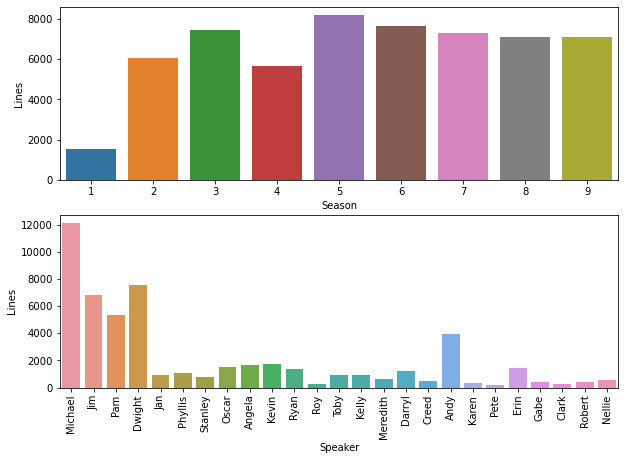

In [23]:
fig, axes = plt.subplots(2, figsize=(10, 7))

df_real = df_dialog[df_dialog.deleted == False]

c = Counter(df_real['season'])
ax = sns.barplot(ax=axes[0], x = list(c.keys()), y = list(c.values()))
ax.set(xlabel="Season", ylabel = "Lines")

main_characters = df[df.Category == "Main_Characters"].index
main_characters_first_name = [char.split(" ")[0] for char in main_characters]
df_main = df_dialog[[speaker in main_characters_first_name for speaker in df_dialog.speaker]]

c = Counter(df_main['speaker'])
ax = sns.barplot(ax=axes[1], x = list(c.keys()), y = list(c.values()))
plt.xticks(rotation=90)
ax.set(xlabel='Speaker', ylabel = "Lines")

In [24]:
dialog_size = getsize(script_path)
print(f"The size of all the files combined is {dialog_size} bytes.")

The size of all the files combined is 3256246 bytes.


### Ratings

In [4]:
ratings_path = "Data/TheOffice_Episodes_IMDb_Ratings.csv"

In [5]:
df_ratings = pd.read_csv(ratings_path)

In [6]:
df_ratings.head()

,season,episode_number,title,airdate,rating,total_votes,desc
0,1,1,Pilot,2005-03-24,7.4,7022,The premiere episode introduces the boss and s...
1,1,2,Diversity Day,2005-03-16,8.3,6918,Michael's off color remark puts a sensitivity ...
2,1,3,Health Care,2005-04-05,7.7,5771,Michael leaves Dwight in charge of picking the...
3,1,4,The Alliance,2005-04-12,8.0,5596,"Just for a laugh, Jim agrees to an alliance wi..."
4,1,5,Basketball,2005-04-19,8.4,6202,Michael and his staff challenge the warehouse ...


[]

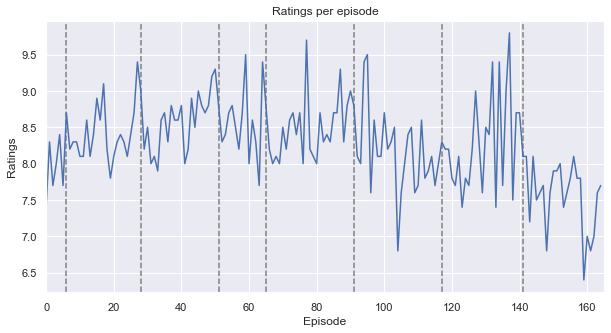

In [27]:
sns.set_theme()

season_change = [i+1 for i in range(len(df_ratings) -1) if df_ratings.season[i] != df_ratings.season[i+1]]

for season in season_change:
    plt.axvline(x=season, color = "grey", linestyle='dashed')
    
ax = sns.lineplot(data = df_ratings.rating)
ax.set(xlabel='Episode', ylabel = "Ratings")
ax.set_title(f"Ratings per episode")
sns.set(rc={'figure.figsize':(10,5)})
plt.xlim(0, len(df_ratings))
ax.plot()

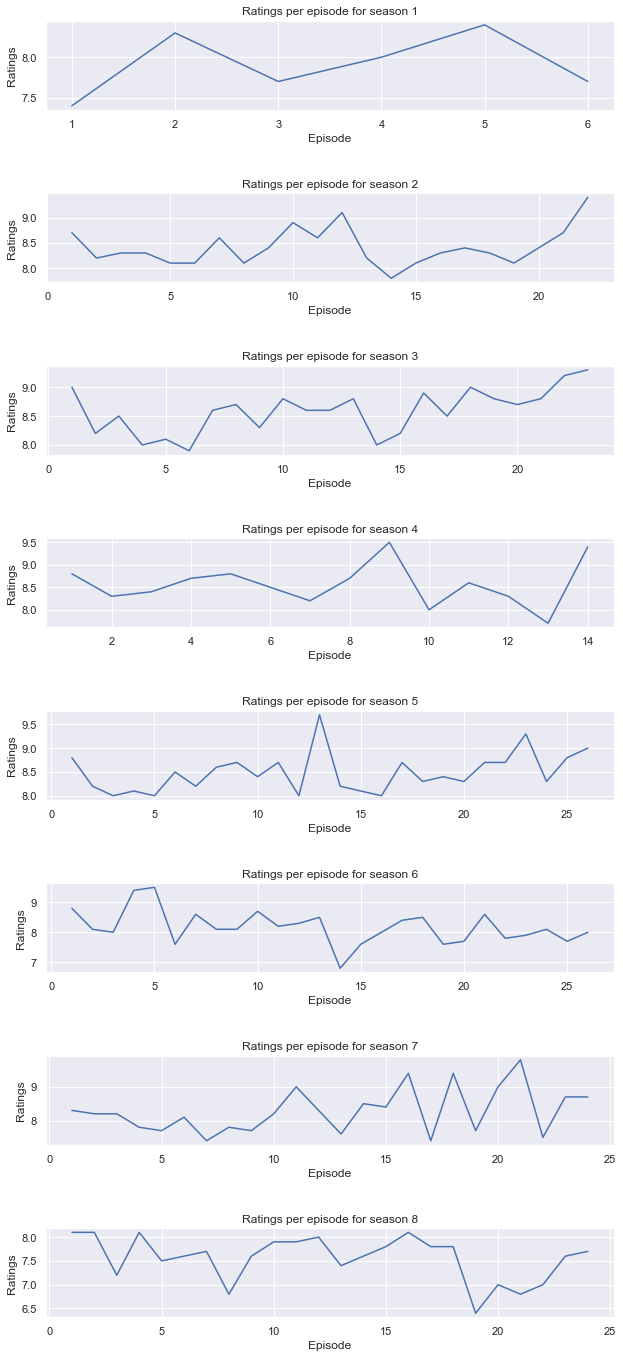

In [36]:
seasons = df_ratings.season.unique()

fig, axes = plt.subplots(len(seasons), figsize=(10, 20))
fig.tight_layout(pad=5.0)

for i,season in enumerate(seasons):
    
    df_season = df_ratings[df_ratings.season == season]
    ax = sns.lineplot(ax = axes[i], data = df_season, x="episode_number", y="rating")
    ax.set(xlabel='Episode', ylabel = "Ratings")
    ax.set_title(f"Ratings per episode for season {season}")

In [37]:
rating_size = getsize(ratings_path)
print(f"The size of all the files combined is {rating_size} bytes.")

The size of all the files combined is 38243 bytes.


In [39]:
print(f"The total size of ALL the data is: {(rating_size + wiki_size + df_size + dialog_size)/1000} KB")

The total size of ALL the data is: 4669.868 KB
